#  Advanced Time Series Analysis - Part 3

## Github link 
https://github.com/Ditto25/IND320-Steamlit-app1.git

## Streamlit link
https://ind320-steamlit-app-ditto.streamlit.app/

## Work Log

I have implemented time series analysis techniques for both weather and energy production data. The work involved:

- API integration
- Signal processing
- Anomaly detection
- Spectral analysis

All of this was wrapped in reusable functions suitable for both Jupyter Notebook and Streamlit deployment.

## Jupyter Notebook Development

### Weather Data API Integration
I started by creating a reference DataFrame mapping Norwegian cities (Oslo, Kristiansand, Trondheim, Tromsø, Bergen) to their geographical coordinates (longitude, latitude) and corresponding electricity price areas (NO1–NO5). I used suggestions from GitHub Copilot to find the coordinates.

Next, I developed a function to download historical weather data from the open-meteo API using the ERA5 reanalysis model. The function takes longitude, latitude, and year as inputs, constructs the API request with weather parameters (temperature, precipitation, wind speed, wind gusts, wind direction), and returns a pandas DataFrame. I tested the function by downloading 2019 data for Bergen, successfully retrieving a full year of hourly measurements as required by the assignment.

### Outlier and Anomaly Detection
For temperature analysis, I implemented a sophisticated outlier detection method combining signal processing and statistical process control (SPC). The function first plots the raw temperature time series, then applies Direct Cosine Transform (DCT) for high-pass filtering, removing seasonal trends to create Seasonally Adjusted Temperature Variations (SATV). Using robust statistics (median and median absolute deviation) calculated from the SATV, the function establishes SPC boundaries at a configurable number of standard deviations (default 3σ). Points outside these boundaries are classified as outliers and visually highlighted. The function is parameterized with sensible defaults for frequency cutoff and standard deviation multiplier, returning both the plot and detailed outlier statistics.

For precipitation analysis, I applied the Local Outlier Factor (LOF) method from scikit-learn to detect anomalies. Unlike the temperature approach, which focuses on high-frequency deviations, LOF identifies points with significantly different local density compared to their neighbors. The function plots precipitation over time, marks LOF-detected anomalies in a contrasting color, and allows configuration of the expected outlier proportion (default 1%). This approach works well for precipitation data with extreme values and irregular patterns

### Time Series Decomposition
I implemented a function for Seasonal-Trend decomposition using LOESS (STL) on Elhub production data. The function queries MongoDB to retrieve production data filtered by electricity price area and production group, then uses statsmodels’ STL to decompose the time series into trend, seasonal, and residual components. All components are plotted in a multi-panel figure for easy interpretation. The function includes parameters for price area, production group, seasonal period length, seasonal and trend smoother strengths, and a robust flag for handling outliers — all with sensible defaults based on typical energy data patterns.

### Spectral Analysis
I developed a spectrogram function to visualize the frequency content of production data over time. Using scipy’s Short-Time Fourier Transform (STFT), the function calculates how frequency components evolve throughout the year. The spectrogram reveals patterns such as daily cycles, weekly patterns, and seasonal shifts in production. Parameters include price area, production group, window length, and window overlap. The resulting plots are color-coded with clear axis labels and a color bar for easy interpretation.

### Streamlit App Updates
I updated the Streamlit app structure according to specifications, reorganizing pages and adding two new pages with tabbed interfaces. The page order changed from 1–2–3–4–5 to 1–4–newA–2–3–newB–5, and pages were renamed for clarity.

The previous CSV import was replaced with open-meteo API calls, dependent on the price area selector (now on page 2), to download data for the selected year. Page “new A” uses st.tabs() with STL analysis in the first tab and spectrogram analysis in the second tab, both featuring interactive parameter controls. Page “new B” similarly uses tabs for temperature outlier/SPC analysis and precipitation anomaly/LOF analysis, with plots and summary statistics displayed based on user-selected parameters.

I have encountered some challenges with the new B page and am not fully satisfied with the current solution, but I plan to continue improving it after the deadline.

Throughout the project, I focused on creating production-ready code with comprehensive docstrings, robust error handling, parameterization with sensible defaults, and clear visualizations. This implementation demonstrates an understanding of advanced signal processing, statistical methods, and time series analysis applied to real-world weather and energy data.
### AI Usage

AI assistance (GitHub Copilot) was utilized throughout the project in several key areas:

API Integration: Guidance with understanding the open-meteo API structure, parameter configuration, and error handling for API requests.

Signal Processing: Help implementing Direct Cosine Transform (DCT) for high-pass filtering and calculating Seasonally Adjusted Temperature Variations (SATV).

Statistical Analysis: Assistance with implementing Statistical Process Control (SPC) boundaries using robust statistics (median and MAD) and configuring the Local Outlier Factor (LOF) algorithm for anomaly detection.

Time Series Decomposition: Support with using statsmodels’ STL decomposition and configuring appropriate parameters.

Spectrogram Generation: Guidance on using scipy’s STFT for creating informative spectrograms from production data.

Data Visualization: Creating professional matplotlib visualizations with multiple subplots, axis labels, color coding, and informative legends.

Function Design and Documentation: Structuring reusable functions with sensible defaults, comprehensive docstrings, proper return values, and detailed comments explaining each step and parameter choice.

AI tools significantly improved development efficiency, code quality, and implementation of complex signal processing and statistical methods while maintaining a full understanding of the underlying algorithms.



## Norwegian Cities and Price Areas 

In [ ]:
import pandas as pd
from urllib.parse import urlencode

# Norway price areas (Nord Pool): NO1..NO5 mapped to representative cities
data = [
    {"price_area": "NO1", "city": "Oslo",         "longitude": 10.7522, "latitude": 59.9139},
    {"price_area": "NO2", "city": "Kristiansand", "longitude": 7.9956,  "latitude": 58.1467},
    {"price_area": "NO3", "city": "Trondheim",    "longitude": 10.3951, "latitude": 63.4305},
    {"price_area": "NO4", "city": "Tromsø",       "longitude": 18.9553, "latitude": 69.6492},
    {"price_area": "NO5", "city": "Bergen",       "longitude": 5.3221,  "latitude": 60.3913},
]
# make DataFrame printing hide the index by default in this notebook
def _df_repr_no_index(self):
    return self.to_string(index=False)
pd.DataFrame.__repr__ = _df_repr_no_index
pd.DataFrame.__str__ = lambda self: _df_repr_no_index(self).upper() # Seems better
locations_df = pd.DataFrame(data)
print(locations_df)


PRICE_AREA         CITY  LONGITUDE  LATITUDE
       NO1         OSLO    10.7522   59.9139
       NO2 KRISTIANSAND     7.9956   58.1467
       NO3    TRONDHEIM    10.3951   63.4305
       NO4       TROMSØ    18.9553   69.6492
       NO5       BERGEN     5.3221   60.3913


In [ ]:
import requests
import pandas as pd
from urllib.parse import urlencode

# Function to build parameters for Open-Meteo API
def build_open_meteo_params(latitude, longitude, year):
    """
    Build a dictionary of parameters for Open-Meteo ERA5 historical reanalysis API.
    """
    return {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": f"{year}-01-01",
        "end_date": f"{year}-12-31",
        "hourly": [
            "temperature_2m",          
            "precipitation",           
            "wind_speed_10m",          
            "wind_gusts_10m",          
            "wind_direction_10m"       
        ],
        "timezone": "auto"
    }
# Function to download data from Open-Meteo API
def download_open_meteo_data(latitude, longitude, year):
    """
    Download historical weather data from Open-Meteo ERA5 reanalysis model.
    Combines parameter builder and actual data retrieval.
    """
    base_url = "https://archive-api.open-meteo.com/v1/archive"
    params = build_open_meteo_params(latitude, longitude, year)

    print(f"Requesting data for ({latitude}, {longitude}) in {year}...")
    
    # Make API call
    response = requests.get(base_url, params=params)

    # Check for errors
    if response.status_code != 200:
        raise Exception(f"Request failed ({response.status_code}): {response.text}")

    data = response.json()
    hourly = data.get("hourly", {})

    if not hourly:
        raise ValueError("No hourly data returned from API.")

    # Build DataFrame
    df = pd.DataFrame({
        "time": pd.to_datetime(hourly["time"]),
        "temperature_2m (°C)": hourly["temperature_2m"],
        "precipitation (mm)": hourly["precipitation"],
        "wind_speed_10m (m/s)": hourly["wind_speed_10m"],
        "wind_gusts_10m (m/s)": hourly["wind_gusts_10m"],
        "wind_direction_10m (°)": hourly["wind_direction_10m"]
    })

    print(f"✅ Successfully downloaded {len(df)} hourly records for {year}.")
    return df



### Test API download function with Bergen 2019

In [ ]:
# Get data for Bergen in 2019
bergen = locations_df[locations_df['city'] == 'Bergen'].iloc[0]
latitude = bergen['latitude']
longitude = bergen['longitude']
year = 2019

# show data for Bergen 2019
df_weather = download_open_meteo_data(latitude, longitude, year)
print("\n First few rows of data for Bergen in 2019:")
print(df_weather.head())

Requesting data for (60.3913, 5.3221) in 2019...
✅ Successfully downloaded 8760 hourly records for 2019.

 First few rows of data for Bergen in 2019:
               TIME  TEMPERATURE_2M (°C)  PRECIPITATION (MM)  WIND_SPEED_10M (M/S)  WIND_GUSTS_10M (M/S)  WIND_DIRECTION_10M (°)
2019-01-01 00:00:00                  5.7                 0.7                  37.0                  99.7                     263
2019-01-01 01:00:00                  5.8                 0.2                  41.0                 107.3                     278
2019-01-01 02:00:00                  6.1                 0.7                  42.0                 112.0                     286
2019-01-01 03:00:00                  6.3                 0.5                  40.9                 105.8                     298
2019-01-01 04:00:00                  5.8                 1.1                  41.2                 110.2                     315


## Temperature Outlier Detection using DCT and SPC

In [ ]:
# detect_temperature_outliers.py

import numpy as np
import pandas as pd
from scipy.fftpack import dct, idct
import pandas as pd
import matplotlib.pyplot as plt

def plot_temperature_outliers(results, column='temperature_2m (°C)'):
    upper_satv = results.get('upper', None)
    lower_satv = results.get('lower', None)
    df_tmp = results.get('data', None)

    outlier_dates = []
    if df_tmp is not None and 'outlier' in df_tmp.columns:
        outlier_mask = df_tmp['outlier'].astype(bool)
        try:
            times = pd.to_datetime(df_tmp.loc[outlier_mask, 'time']).head(10)
            temps = df_tmp.loc[outlier_mask, column].head(10)
            outlier_dates = [
                f"{t.strftime('%Y-%m-%d %H:%M')} — {temp:.2f}°C"
                for t, temp in zip(times, temps)
            ]
        except Exception:
            outlier_dates = df_tmp.loc[outlier_mask, 'time'].head(10).tolist()

    if upper_satv is not None and lower_satv is not None:
        print(f"SPC boundaries in SATV space: upper={upper_satv:.4f}, lower={lower_satv:.4f}")
    else:
        print("SPC boundaries not available in results.")

    if outlier_dates:
        print("First 10 outlier timestamps:")
        for dt in outlier_dates:
            print(f" - {dt}")
    else:
        print("No outlier timestamps found in results.")

    df = results['data']
    satv = results['satv']
    n_outliers = results['n_outliers']

    # NEW: Safety check
    if len(satv) != len(df):
        raise ValueError(f"SATV length {len(satv)} does not match df length {len(df)}.")

    satv_series = pd.Series(satv, index=df.index)
    seasonal_trend = df[column].astype(float) - satv_series


C:\Users\Erik\AppData\Local\Temp\ipykernel_21316\2756372552.py:56: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  temps_series = temps_series.fillna(method='ffill').fillna(method='bfill')


SPC boundaries in SATV space: upper=6.0280, lower=-6.2727
First 10 outlier timestamps:
 - 2019-02-02 14:00 — -0.50°C
 - 2019-04-04 12:00 — 16.40°C
 - 2019-04-04 13:00 — 16.90°C
 - 2019-04-04 14:00 — 17.50°C
 - 2019-04-04 15:00 — 17.40°C
 - 2019-04-04 16:00 — 17.10°C
 - 2019-04-05 01:00 — 3.90°C
 - 2019-04-05 03:00 — 3.70°C
 - 2019-04-05 11:00 — 16.40°C
 - 2019-04-05 12:00 — 17.60°C
Example mapped temperature boundaries at median seasonal trend (7.3070°C):
  Mapped upper: 13.3351°C
  Mapped lower: 1.0343°C


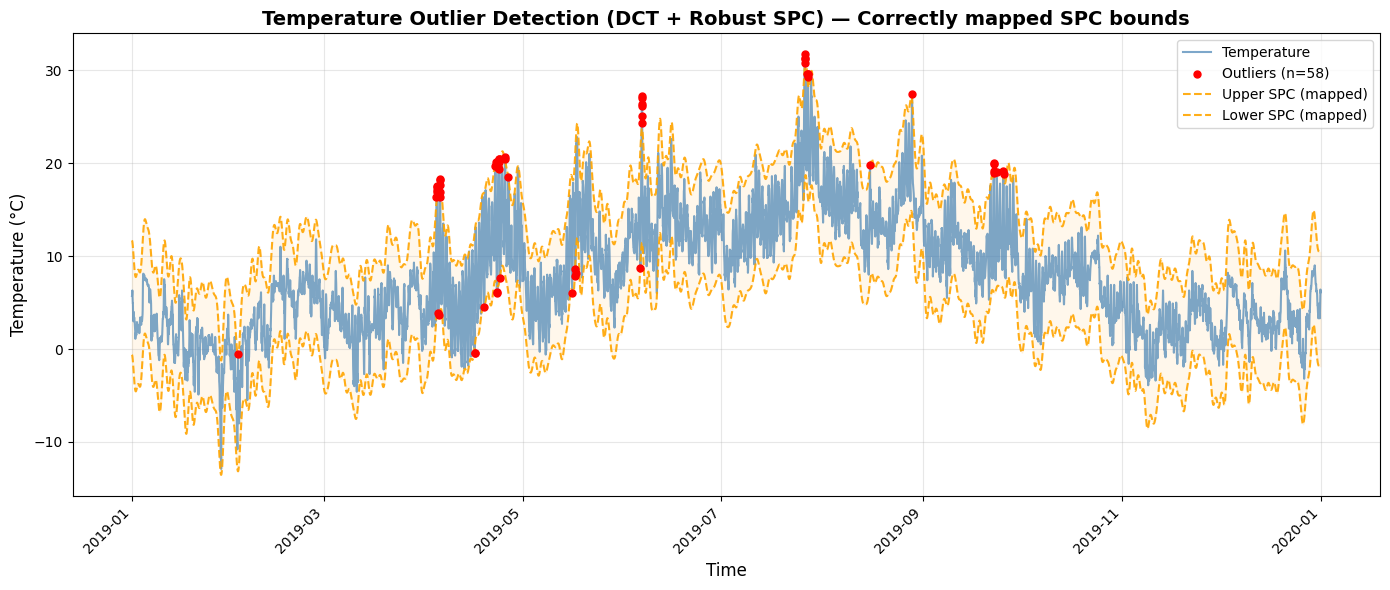

Detected 58 outliers (0.66%) in temperature data.


In [42]:
# plot_temperature_outliers.py

import matplotlib.pyplot as plt

def plot_temperature_outliers(results, column='temperature_2m (°C)'):
    """
    Plot temperature series with detected outliers and SPC boundaries.

    Notes:
    - SPC limits in `results['upper']` / `results['lower']` are computed in SATV (high-frequency)
      space. To plot correctly in temperature space we map them as:
        temperature_boundary(t) = seasonal_trend(t) + satv_boundary
      where seasonal_trend(t) = temperature(t) - satv(t).
    """
    # Prepare and print summary info (boundaries and up to 10 outlier dates)
    upper_satv = results.get('upper', None)
    lower_satv = results.get('lower', None)
    df_tmp = results.get('data', None)

    outlier_dates = []
    if df_tmp is not None and 'outlier' in df_tmp.columns:
        try:
            times = pd.to_datetime(df_tmp.loc[df_tmp['outlier'], 'time']).head(10)
            temps = df_tmp.loc[df_tmp['outlier'], column].head(10)
            outlier_dates = [f"{t.strftime('%Y-%m-%d %H:%M')} — {temp:.2f}°C" for t, temp in zip(times, temps)]
        except Exception:
            outlier_dates = df_tmp.loc[df_tmp['outlier'], 'time'].head(10).tolist()

    if upper_satv is not None and lower_satv is not None:
        print(f"SPC boundaries in SATV space: upper={upper_satv:.4f}, lower={lower_satv:.4f}")
    else:
        print("SPC boundaries not available in results.")

    if outlier_dates:
        print("First 10 outlier timestamps:")
        for dt in outlier_dates:
            print(f" - {dt}")
    else:
        print("No outlier timestamps found in results.")

    # Unpack results
    df = results['data']
    satv = results['satv']
    n_outliers = results['n_outliers']

    # Align SATV with df and compute seasonal trend
    satv_series = pd.Series(satv, index=df.index)
    seasonal_trend = df[column].astype(float) - satv_series

    # Map SATV SPC boundaries into temperature space (a time-varying pair of lines)
    if upper_satv is not None and lower_satv is not None:
        temp_upper = seasonal_trend + upper_satv
        temp_lower = seasonal_trend + lower_satv
        # For concise print, show mapped boundaries at median seasonal trend
        median_seasonal = seasonal_trend.median()
        print(f"Example mapped temperature boundaries at median seasonal trend ({median_seasonal:.4f}°C):")
        print(f"  Mapped upper: {median_seasonal + upper_satv:.4f}°C")
        print(f"  Mapped lower: {median_seasonal + lower_satv:.4f}°C")
    else:
        temp_upper = temp_lower = None

    plt.figure(figsize=(14, 6))

    # Plot original temperatures
    plt.plot(df['time'], df[column], color='steelblue', alpha=0.7, label='Temperature')

    # Mark outliers in red
    plt.scatter(df.loc[df['outlier'], 'time'],
                df.loc[df['outlier'], column],
                color='red', s=25, label=f'Outliers (n={n_outliers})', zorder=3)

    # Plot mapped SPC boundaries (time-varying)
    if temp_upper is not None and temp_lower is not None:
        plt.plot(df['time'], temp_upper, color='orange', linestyle='--', alpha=0.9, label='Upper SPC (mapped)')
        plt.plot(df['time'], temp_lower, color='orange', linestyle='--', alpha=0.9, label='Lower SPC (mapped)')
        # Optional: shaded area between boundaries
        plt.fill_between(df['time'], temp_lower, temp_upper, color='orange', alpha=0.08)

    # Formatting
    plt.title('Temperature Outlier Detection (DCT + Robust SPC) — Correctly mapped SPC bounds', fontsize=14, weight='bold')
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Temperature (°C)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Run detection and plot (using existing df_weather)
results = detect_temperature_outliers(df_weather)
plot_temperature_outliers(results)
print(f"Detected {results['n_outliers']} outliers ({results['outlier_pct']:.2f}%) in temperature data.")


## Precipitation Anomaly Detection using LOF (Local Outlier Factor)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor

def detect_precipitation_outliers_combined(df, column='precipitation (mm)', contamination=0.01, use_trend=False):
    """
    Detect precipitation anomalies using the Local Outlier Factor (LOF) method.
    Supports both simple outlier detection and trend-aware anomaly detection.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with columns ['time', column]
    column : str
        Precipitation column name (default: 'precipitation (mm)')
    contamination : float
        Expected proportion of anomalies (default 0.01 = 1%)
    use_trend : bool
        If True, includes rate of change (Δprecipitation) as a second feature for detection.
        If False, detects outliers based only on precipitation values.

    Returns
    -------
    data : pd.DataFrame
        Original DataFrame with added 'outlier' column (True for anomalies)
    summary : dict
        {
            'n_outliers': int,
            'outlier_percentage': float,
            'outlier_dates': list,
            'outlier_values': list,
            'lof_scores': np.ndarray
        }
    """

    data = df.copy().dropna(subset=[column, 'time'])
    precip = data[column].values

    # ---- Feature setup ----
    if use_trend:
        precip_diff = np.diff(precip, prepend=precip[0])  # rate of change
        X = np.column_stack([precip, precip_diff])        # 2D feature space
    else:
        X = precip.reshape(-1, 1)                         # 1D feature space

    # ---- LOF model ----
    lof = LocalOutlierFactor(n_neighbors=20, contamination=contamination)
    y_pred = lof.fit_predict(X)
    lof_scores = lof.negative_outlier_factor_

    # ---- Mark anomalies ----
    data['outlier'] = (y_pred == -1)
    n_outliers = data['outlier'].sum()
    outlier_pct = (n_outliers / len(data)) * 100

    # ---- Summary ----
    summary = {
        'n_outliers': n_outliers,
        'outlier_percentage': outlier_pct,
        'outlier_dates': data.loc[data['outlier'], 'time'].tolist(),
        'outlier_values': data.loc[data['outlier'], column].tolist(),
        'lof_scores': lof_scores,
        'mode': 'trend-aware' if use_trend else 'value-only'
    }

    return data, summary


In [ ]:
import matplotlib.pyplot as plt

def plot_precipitation_outliers_combined(df, column='precipitation (mm)', summary=None):
    """
    Plot precipitation over time, highlighting detected outliers.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame returned by `detect_precipitation_outliers_combined`
    column : str
        Precipitation column name
    summary : dict
        Summary returned by detection function (optional)
    """
    fig, ax = plt.subplots(figsize=(13, 6))

    # Plot inliers
    ax.plot(df.loc[~df['outlier'], 'time'],
            df.loc[~df['outlier'], column],
            color='skyblue', linewidth=1.5, label='Normal precipitation')

    # Plot outliers
    ax.scatter(df.loc[df['outlier'], 'time'],
               df.loc[df['outlier'], column],
               color='red', s=40, label='Detected anomalies', zorder=3)

    # Title info
    mode = summary.get('mode', 'value-only') if summary else 'value-only'
    n_out = summary.get('n_outliers', df['outlier'].sum())
    pct = summary.get('outlier_percentage', df['outlier'].sum() / len(df) * 100)

    ax.set_title(f"Precipitation Anomaly Detection (LOF, mode={mode})\n"
                 f"Detected {n_out} anomalies ({pct:.2f}%)",
                 fontsize=14, fontweight='bold', pad=10)
    ax.set_xlabel("Time", fontsize=12)
    ax.set_ylabel(column, fontsize=12)
    ax.legend()
    ax.grid(alpha=0.3)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    return fig


Using Bergen (60.3913, 5.3221) precipitation for 2019


c:\Users\Erik\miniconda3\envs\D2D_env\Lib\site-packages\sklearn\neighbors\_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


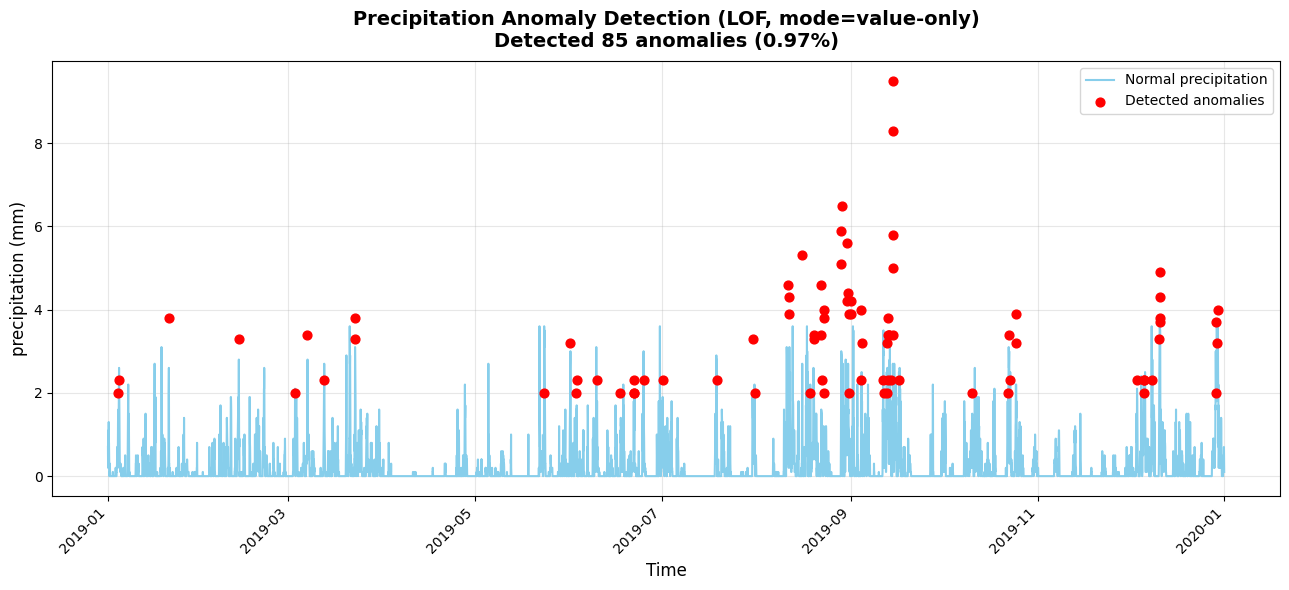

Detected 85 outliers (0.97%)
Sample outliers (up to 10):
 - 2019-01-04 09:00:00: 2.0
 - 2019-01-04 16:00:00: 2.3
 - 2019-01-20 21:00:00: 3.8
 - 2019-02-12 18:00:00: 3.3
 - 2019-03-03 05:00:00: 2.0
 - 2019-03-07 05:00:00: 3.4
 - 2019-03-12 16:00:00: 2.3
 - 2019-03-22 20:00:00: 3.8
 - 2019-03-22 21:00:00: 3.3
 - 2019-05-23 14:00:00: 2.0


In [ ]:
# Single test plot using Bergen precipitation (value-only LOF)
bergen_row = locations_df[locations_df['city'] == 'Bergen'].iloc[0]
print(f"Using Bergen ({bergen_row['latitude']}, {bergen_row['longitude']}) precipitation for 2019")

# prepare dataframe with expected column name
df = df_weather[['time', 'precipitation (mm)']].copy()
df['time'] = pd.to_datetime(df['time'])

# Run LOF (value-only) and plot a single figure
data, summary = detect_precipitation_outliers_combined(df, contamination=0.01, use_trend=False)
fig = plot_precipitation_outliers_combined(data, summary=summary)
plt.show()

# Print concise summary
print(f"Detected {summary['n_outliers']} outliers ({summary['outlier_percentage']:.2f}%)")
print("Sample outliers (up to 10):")
for dt, val in list(zip(summary['outlier_dates'], summary['outlier_values']))[:10]:
    print(f" - {pd.to_datetime(dt)}: {val}")


## STL Decomposition for Elhub Production Data

In [10]:
from pymongo import MongoClient
import toml

# Load Mongo URI
secrets = toml.load(".streamlit/secrets.toml")
uri = secrets["MONGO"]["uri"]

client = MongoClient(uri)
db = client['Database']      #name of the database
collection = db['data']      #name of the collection

# Check unique values
price_areas = collection.distinct("priceArea")
prod_groups = collection.distinct("productionGroup")

print("Available price areas:", price_areas)
print("Available production groups:", prod_groups)


Available price areas: ['NO1', 'NO2', 'NO3', 'NO4', 'NO5']
Available production groups: ['hydro', 'other', 'solar', 'thermal', 'wind']


In [11]:
from pymongo import MongoClient
from pymongo.server_api import ServerApi
import pandas as pd
import toml
import matplotlib.pyplot as plt
def stl_decomposition(priceArea='NO1', productionGroup='hydro', 
                     period=24, seasonal=7, trend=None, robust=False):
    """
    Perform STL (Seasonal-Trend decomposition using LOESS) on elhub production data.
    
    STL decomposes a time series into three components:
    - Trend: Long-term progression of the series
    - Seasonal: Repeating patterns (daily, weekly, etc.)
    - Residual: Remainder after removing trend and seasonal components
    """
    
    # --- Obtain MongoDB URI (robust fallback) ---
    uri = None
    # 1) Try Streamlit secrets.toml
    try:
        secrets = toml.load(".streamlit/secrets.toml")
        uri = secrets.get("MONGO", {}).get("uri")
    except Exception:
        # ignore if file missing or malformed
        secrets = {}
    # Create a new client and connect to the server
    client = MongoClient(uri, server_api=ServerApi('1'))
    # Verify connection
    try:
        client.admin.command('ping')
        print("Pinged your deployment. Successfully connected to MongoDB!")
    except Exception as e:
        raise RuntimeError(f"Failed to ping MongoDB: {e}")
    client = MongoClient(uri, server_api=ServerApi('1'))
    db = client['Database']      
    collection = db['data']      

    # Query data for specified price area and production group
    query = {
        'priceArea': priceArea ,
        'productionGroup': productionGroup
    }

# print
    print(f"Querying MongoDB for {productionGroup} production in {priceArea}...")
    cursor = collection.find(query).sort('startTime', 1)  # Sort by time
    data = list(cursor)
    
    if len(data) == 0:
        raise ValueError(f"No data found for {productionGroup} in {priceArea}")
    
    # Convert to DataFrame
    df = pd.DataFrame(data)
    df['startTime'] = pd.to_datetime(df['startTime'], utc=True)
    df = df.sort_values('startTime')
    
    # Create time series
    ts = pd.Series(
        df['quantityKwh'].values,
        index=df['startTime']
    )

#Print to see if the connection to the database work with this function
    print(f"loaded {len(ts)} production records for {productionGroup} in {priceArea}.")
    # Interpolate missing values use obj.ffill().bfill()
    ts = ts.ffill().bfill()

stl_decomposition(priceArea='NO5', productionGroup='hydro')

Pinged your deployment. Successfully connected to MongoDB!
Querying MongoDB for hydro production in NO5...
loaded 8760 production records for hydro in NO5.


In [12]:
# --- Imports ---
from pymongo import MongoClient
from pymongo.server_api import ServerApi
import pandas as pd
import numpy as np
import toml
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL


# --- MongoDB connection ---
def get_mongo_collection():
    """Connect to MongoDB and return the elhub production collection."""
    secrets = toml.load(".streamlit/secrets.toml")
    uri = secrets["MONGO"]["uri"]
    client = MongoClient(uri, server_api=ServerApi('1'))

    # Check connection
    client.admin.command('ping')
    print("✅ Connected to MongoDB")

    db = client["Database"]
    collection = db["data"]
    return collection


In [13]:
def load_production_data(priceArea="NO1", productionGroup="hydro"):
    """Load production data for given area/group and return a pandas Series."""
    collection = get_mongo_collection()
    
    query = {"priceArea": priceArea, "productionGroup": productionGroup}
    cursor = collection.find(query).sort("startTime", 1)
    data = list(cursor)
    
    if len(data) == 0:
        raise ValueError(f"No data found for {productionGroup} in {priceArea}")
    
    df = pd.DataFrame(data)
    df["startTime"] = pd.to_datetime(df["startTime"], utc=True)
    df = df.sort_values("startTime")
    
    ts = pd.Series(df["quantityKwh"].values, index=df["startTime"])
    ts = ts.interpolate().fillna(method="bfill").fillna(method="ffill")
    
    print(f"Loaded {len(ts)} records for {productionGroup} in {priceArea}")
    return ts


In [14]:
def stl_decomposition(priceArea="NO1", productionGroup="hydro",
                      period=24, seasonal=7, trend=None, robust=True):
    """
    Perform STL decomposition on elhub production data and return a plot + results.
    """
    try:
        ts = load_production_data(priceArea, productionGroup)
    except ValueError as e:
        print(f"⚠️ {e}")
        return None
    
    # Perform STL decomposition
    stl = STL(ts, period=period, seasonal=seasonal, trend=trend, robust=robust)
    result = stl.fit()
    
    # Plot decomposition
    fig, axes = plt.subplots(4, 1, figsize=(15, 10), sharex=True)
    axes[0].plot(ts.index, ts.values, color='black')
    axes[0].set_title(f"STL Decomposition: {productionGroup} ({priceArea})", fontsize=14)
    axes[0].set_ylabel("Original")

    axes[1].plot(ts.index, result.trend, color='blue')
    axes[1].set_ylabel("Trend")

    axes[2].plot(ts.index, result.seasonal, color='green')
    axes[2].set_ylabel("Seasonal")

    axes[3].plot(ts.index, result.resid, color='red')
    axes[3].set_ylabel("Residual")
    axes[3].set_xlabel("Time")

    plt.tight_layout()
    plt.show()

    return {
        "figure": fig,
        "trend": result.trend,
        "seasonal": result.seasonal,
        "residual": result.resid,
        "stl_result": result
    }


✅ Connected to MongoDB


C:\Users\Erik\AppData\Local\Temp\ipykernel_21316\2272809963.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = ts.interpolate().fillna(method="bfill").fillna(method="ffill")


Loaded 8760 records for hydro in NO5


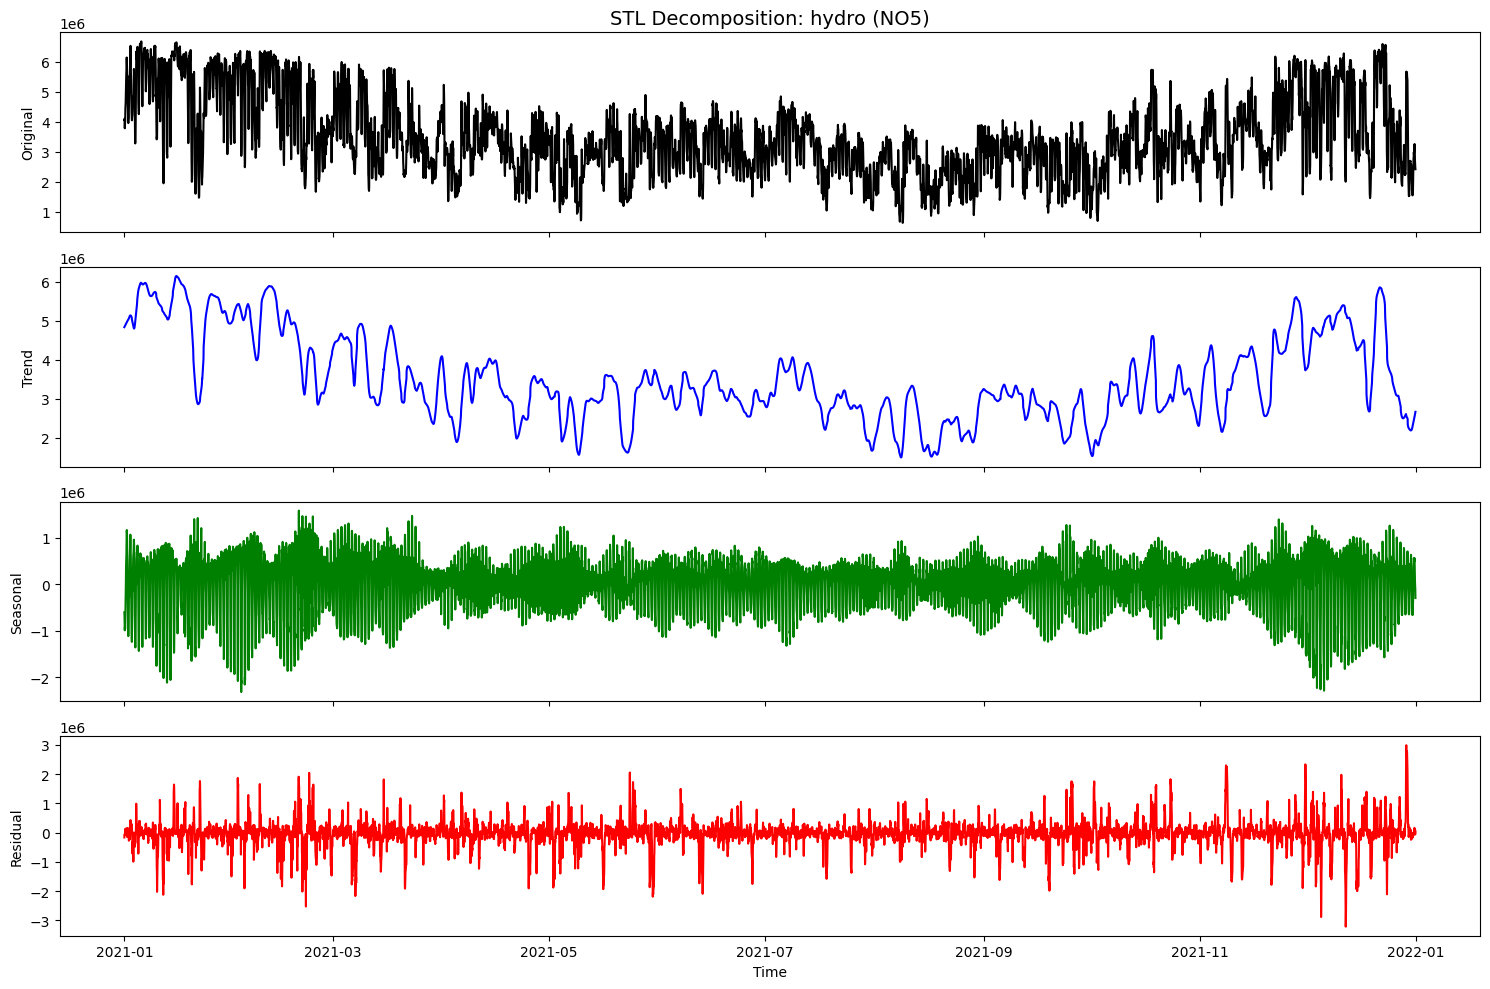


--- STL Component Stats ---
Trend mean: 3496560.76, std: 1066269.22
Seasonal mean: -202.55, std: 569058.49
Residual mean: -33245.47, std: 460066.69


In [15]:
# --- Run decomposition ---
results = stl_decomposition(
    priceArea="NO5",
    productionGroup="hydro",
    period=24,
    seasonal=7,
    trend=None,
    robust=True
)

if results:
    print("\n--- STL Component Stats ---")
    print(f"Trend mean: {np.mean(results['trend']):.2f}, std: {np.std(results['trend']):.2f}")
    print(f"Seasonal mean: {np.mean(results['seasonal']):.2f}, std: {np.std(results['seasonal']):.2f}")
    print(f"Residual mean: {np.mean(results['residual']):.2f}, std: {np.std(results['residual']):.2f}")
#Testing the STL function function

## Spectrogram for Elhub production Data

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
def plot_production_spectrogram(priceArea='NO1',
                                productionGroup='hydro',
                                window_length=256,
                                overlap=128):
    """
    Create a spectrogram for electricity production data from Elhub.

    Parameters
    ----------
    priceArea : str
        Electricity price area (e.g., 'NO1', 'NO2', etc.)
    productionGroup : str
        Type of production (e.g., 'hydro', 'wind', 'thermal')
    window_length : int
        Number of samples per analysis window
    overlap : int
        Number of samples overlapped between windows

    Returns
    -------
    dict
        Contains figure, frequencies, times, and spectrogram matrix
    """

    # --- Connect to MongoDB ---
    from pymongo import MongoClient
    from pymongo.server_api import ServerApi
    import toml
    import pandas as pd

    try:
        secrets = toml.load(".streamlit/secrets.toml")
        uri = secrets.get("MONGO", {}).get("uri")
    except Exception:
        uri = None

    client = MongoClient(uri, server_api=ServerApi("1"))
    db = client["Database"]
    collection = db["data"]

    query = {
        "priceArea": priceArea,
        "productionGroup": productionGroup
    }

    print(f"Querying MongoDB for {productionGroup} production in {priceArea}...")
    cursor = collection.find(query).sort("startTime", 1)
    data = list(cursor)

    if len(data) == 0:
        raise ValueError(f"No data found for {productionGroup} in {priceArea}")

    df = pd.DataFrame(data)
    df["startTime"] = pd.to_datetime(df["startTime"], utc=True)
    df = df.sort_values("startTime")

    ts = pd.Series(df["quantityKwh"].values, index=df["startTime"])
    ts = ts.interpolate().fillna(method="bfill").fillna(method="ffill")

    print(f"Loaded {len(ts)} records for {productionGroup} in {priceArea}.")

    # --- Compute Spectrogram ---
    fs = 1.0  # sampling frequency (1 sample/hour if hourly data)
    f, t, Sxx = spectrogram(ts.values, fs=fs, nperseg=window_length, noverlap=overlap)

    # --- Plot Spectrogram ---
    fig, ax = plt.subplots(figsize=(12, 6))
    im = ax.pcolormesh(t, f, 10 * np.log10(Sxx), shading="gouraud", cmap="viridis")
    fig.colorbar(im, ax=ax, label="Power (dB)")

    ax.set_title(f"Spectrogram of {productionGroup.capitalize()} Production ({priceArea})", fontsize=14, fontweight="bold", pad=15)
    ax.set_xlabel("Time (hours)", fontsize=12, fontweight="bold")
    ax.set_ylabel("Frequency (cycles/hour)", fontsize=12, fontweight="bold")
    plt.tight_layout()

    results = {
        "figure": fig,
        "frequencies": f,
        "times": t,
        "spectrogram": Sxx
    }

    return results


Querying MongoDB for hydro production in NO5...


C:\Users\Erik\AppData\Local\Temp\ipykernel_21316\2881576870.py:61: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = ts.interpolate().fillna(method="bfill").fillna(method="ffill")


Loaded 8760 records for hydro in NO5.


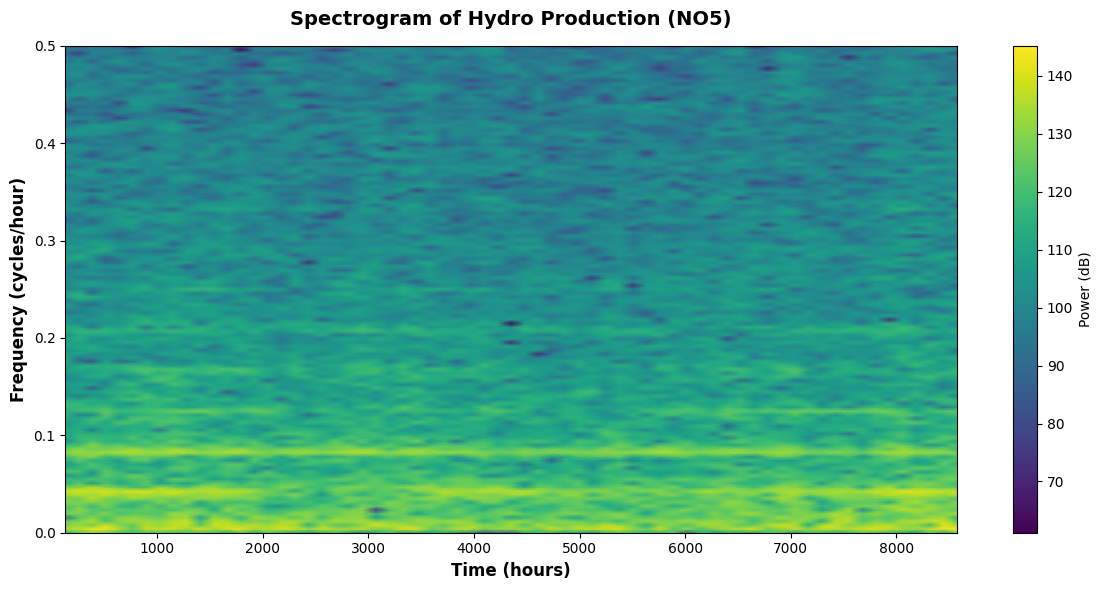


Spectrogram computed successfully!
Frequency range: 0.000000 to 0.500000 cycles/hour
Time range: 128.0 to 8576.0 hours
Spectrogram shape: (129, 67)


In [17]:
spectrogram_results = plot_production_spectrogram(
    priceArea="NO5",
    productionGroup="hydro",
    window_length=256,
    overlap=128
)

plt.show()

print(f"\nSpectrogram computed successfully!")
print(f"Frequency range: {spectrogram_results['frequencies'].min():.6f} to {spectrogram_results['frequencies'].max():.6f} cycles/hour")
print(f"Time range: {spectrogram_results['times'].min():.1f} to {spectrogram_results['times'].max():.1f} hours")
print(f"Spectrogram shape: {spectrogram_results['spectrogram'].shape}")
# Test the spectrogram function